In [1]:
import datetime
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pwlf
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
def createAmortized(principal, payment, apr, beginningDate, oneTimePayment=0, periodicPayment=0, extraPayment_df = pd.DataFrame()):
    output = {
        'ppmt': [],
        'ipmt': [],
        'principal': []
    }
    dateArray = []
    currentDate = beginningDate
    currentPrincipal = principal
    while(currentPrincipal > 0.01):
        previousDate = currentDate
        currentDate += dateutil.relativedelta.relativedelta(months=1)
        interestPaid = currentPrincipal * (apr/12)
        
        #Calculate additional payment if any
        additionalPayment = 0
        if(currentDate > datetime.date.today()):
            additionalPayment += periodicPayment
        if(previousDate <= datetime.date.today() <= currentDate):
            additionalPayment += oneTimePayment
        if not extraPayment_df.empty:
            additionalPayment += extraPayment_df[(previousDate < extraPayment_df['date']) & (extraPayment_df['date'] <= currentDate)]['amount'].sum()
        
        principalPaid = (payment + additionalPayment) - interestPaid
        if(currentPrincipal - principalPaid < 0.00):
            principalPaid = currentPrincipal
            currentPrincipal = 0.00
        else:
            currentPrincipal -= principalPaid
        dateArray.append(currentDate)
        output['ppmt'].append(principalPaid)
        output['ipmt'].append(interestPaid)
        output['principal'].append(currentPrincipal)
    return pd.DataFrame(output, index=dateArray)

def totalInterest(df):
    return np.sum(df['ipmt'])

def endDate(df):
    return df.index.max()

def periodicPaymentReport(principal, payment, apr, beginningDate, start, end, step):
    periodicPaymentArray = []
    interestArray = []
    endDateArray = []
    currentPeriodicPayment = start
    while(currentPeriodicPayment <= end):
        periodicPaymentArray.append(currentPeriodicPayment)
        mod_df = createAmortized(principal, payment, apr, beginningDate, periodicPayment = currentPeriodicPayment)
        interestArray.append(totalInterest(mod_df))
        endDateArray.append(endDate(mod_df))
        currentPeriodicPayment += step
    output = pd.DataFrame({'totalInterest': interestArray, 'endDate': endDateArray}, index=periodicPaymentArray)
    original_df = createAmortized(principal, payment, apr, beginningDate)
    originalInterest = totalInterest(original_df)
    originalEndDate = endDate(original_df)
    output['interest_difference'] = originalInterest - output['totalInterest']
    output['endDate_difference'] = originalEndDate - output['endDate']
    return output

def oneTimePaymentReport(principal, payment, apr, beginningDate, start, end, step):
    oneTimeArray = []
    interestArray = []
    endDateArray = []
    currentOneTimePayment = start
    while(currentOneTimePayment <= end):
        oneTimeArray.append(currentOneTimePayment)
        mod_df = createAmortized(principal, payment, apr, beginningDate, oneTimePayment = currentOneTimePayment)
        interestArray.append(totalInterest(mod_df))
        endDateArray.append(endDate(mod_df))
        currentOneTimePayment += step
    output = pd.DataFrame({'totalInterest': interestArray, 'endDate': endDateArray}, index=oneTimeArray)
    original_df = createAmortized(principal, payment, apr, beginningDate)
    originalInterest = totalInterest(original_df)
    originalEndDate = endDate(original_df)
    output['interest_difference'] = originalInterest - output['totalInterest']
    output['endDate_difference'] = originalEndDate - output['endDate']
    return output

def report(principal, payment, apr, beginningDate, oneTimePayment=0, periodicPayment=0, extraPayment_df = pd.DataFrame()):
    additionalPayment = (oneTimePayment != 0 or periodicPayment != 0 or not extraPayment_df.empty)
    df = createAmortized(principal=principal, payment=payment, apr=apr, beginningDate=beginningDate)
    df_modified = None
    plt_items = ['ppmt', 'ipmt']
    plt2_items = ['principal']
    if additionalPayment:
        df_modified = createAmortized(principal=principal, payment=payment, apr=apr, beginningDate=beginningDate, oneTimePayment=oneTimePayment, periodicPayment=periodicPayment, extraPayment_df = extraPayment_df)
        df['ppmt_mod'] = df_modified['ppmt']
        df['ipmt_mod'] = df_modified['ipmt']
        df['principal_mod'] = df_modified['principal']
        plt_items.append('ppmt_mod')
        plt_items.append('ipmt_mod')
        plt2_items.append('principal_mod')
        
    df[plt_items].plot()
    plt.figure()
    df[plt2_items].plot()
    
    totalInterest_orig = totalInterest(df)
    endDate_orig = endDate(df)
    if additionalPayment:
        
        print("Original Data:")
    print("Total Interest: %d" % totalInterest_orig)
    print("End Date: %s" % endDate_orig)
    
    if additionalPayment:
        totalInterest_mod = totalInterest(df_modified)
        endDate_mod = endDate(df_modified)
        print("")
        print("Modified Data:")
        print("Total Interest: %d" % totalInterest_mod)
        print("End Date: %s" % endDate_mod)
        print("")
        print("Difference in total interest: %d" % (totalInterest_orig - totalInterest_mod))
        print("Difference in end date: %s" % (endDate_orig - endDate_mod))

## House Loan

<div>Beginning Principal: 188000.00</div>
<div>APR: 3.75%</div>
<div>Beginning Date: Fri Oct 27 2017</div>
<div>Payment: $870.66</div>

Original Data:
Total Interest: 125435
End Date: 2047-10-27

Modified Data:
Total Interest: 26032
End Date: 2028-09-27

Difference in total interest: 99402
Difference in end date: 6969 days, 0:00:00


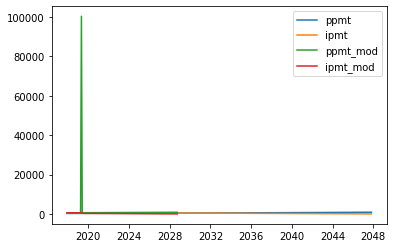

<Figure size 432x288 with 0 Axes>

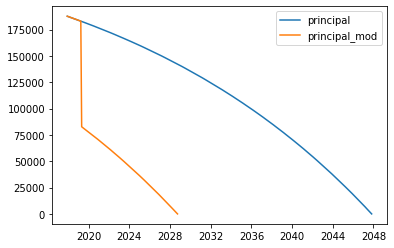

In [3]:
extraPayment_df = pd.DataFrame({
    'date': [datetime.date(2019, 4, 27)],
    'amount': [100000.00]
})

#createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), extraPayment_df=extraPayment_df)
report(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), extraPayment_df=extraPayment_df)

Total Interest: 125435
End Date: 2047-10-27


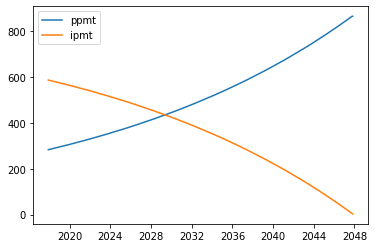

<Figure size 432x288 with 0 Axes>

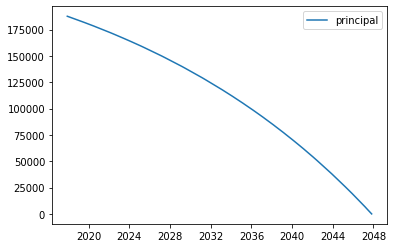

In [4]:
report(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27))

Original Data:
Total Interest: 125435
End Date: 2047-10-27

Modified Data:
Total Interest: 83995
End Date: 2038-03-27

Difference in total interest: 41440
Difference in end date: 3501 days, 0:00:00


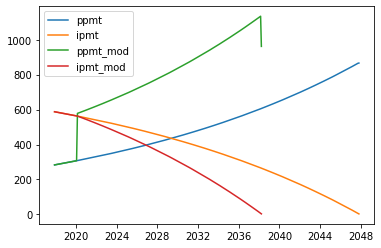

<Figure size 432x288 with 0 Axes>

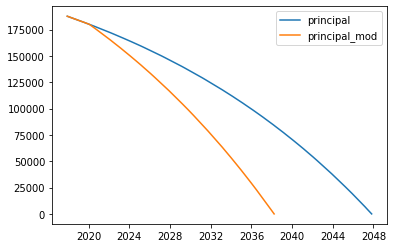

In [5]:
report(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), periodicPayment=270.00)

Original Data:
Total Interest: 125435
End Date: 2047-10-27

Modified Data:
Total Interest: 120096
End Date: 2047-01-27

Difference in total interest: 5339
Difference in end date: 273 days, 0:00:00


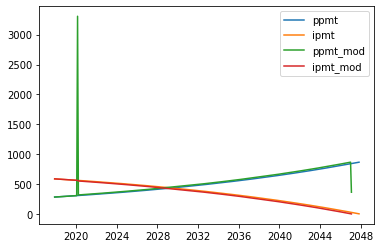

<Figure size 432x288 with 0 Axes>

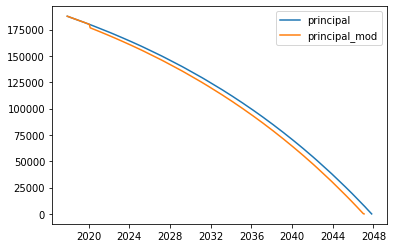

In [6]:
report(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), oneTimePayment=3000.00)

[   0.          421.8287606  1571.89935594 5000.        ]


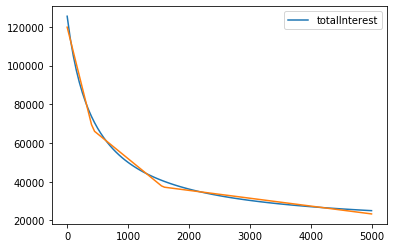

      totalInterest     endDate  interest_difference endDate_difference
0     125435.815428  2047-10-27             0.000000             0 days
50    114180.480102  2045-04-27         11255.335326           913 days
100   105101.496095  2043-03-27         20334.319332          1675 days
150    97607.719025  2041-06-27         27828.096403          2313 days
200    91307.921283  2039-12-27         34127.894144          2861 days
250    85932.546905  2038-09-27         39503.268522          3317 days
300    81287.391209  2037-07-27         44148.424219          3744 days
350    77231.380100  2036-08-27         48204.435328          4078 days
400    73657.683603  2035-09-27         51778.131824          4413 days
450    70482.823053  2034-11-27         54952.992374          4717 days
500    67643.928565  2034-03-27         57791.886863          4962 days
550    65088.936106  2033-07-27         60346.879321          5205 days
600    62777.052118  2032-12-27         62658.763309          54

In [59]:
periodic_df = periodicPaymentReport(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), start=0, end=5000, step=50)
periodic_df[['totalInterest']].plot()

my_pwlf = pwlf.PiecewiseLinFit(periodic_df.index, periodic_df['totalInterest'])
breaks = my_pwlf.fit(3)
print(breaks)

x_hat = periodic_df.index
y_hat = my_pwlf.predict(periodic_df.index)

plt.plot(x_hat, y_hat, '-')
plt.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=periodic_df.index,
    y=periodic_df['totalInterest'],
    name='totalInterest'))
fig.add_trace(go.Scatter(
    x=x_hat,
    y=y_hat,
    name='ipmt_mod'))
fig.show()

print(periodic_df)

totalInterest     endDate  interest_difference endDate_difference
0      125435.815428  2047-10-27             0.000000             0 days
1000   123628.251455  2047-07-27          1807.563973            92 days
2000   121848.515790  2047-04-27          3587.299638           183 days
3000   120096.106873  2047-01-27          5339.708555           273 days
4000   118370.530074  2046-10-27          7065.285353           365 days
5000   116671.297610  2046-07-27          8764.517817           457 days
6000   114997.928455  2046-04-27         10437.886972           548 days
7000   113349.948261  2046-01-27         12085.867167           638 days
8000   111726.889273  2045-10-27         13708.926154           730 days
9000   110128.290249  2045-07-27         15307.525178           822 days
10000  108553.696378  2045-04-27         16882.119049           913 days

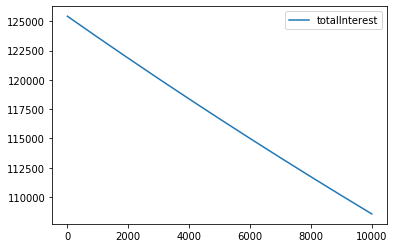

In [7]:
oneTime_df = oneTimePaymentReport(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), start=0, end=10000, step=1000)
oneTime_df[['totalInterest']].plot()
oneTime_df

In [8]:
extraPayment_df = pd.DataFrame({
    'date': [ datetime.date(2019, 4, 27)],
    'amount': [ 100000.00 ]
})

#createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), oneTimePayment=3000.00, extraPayment_df=extraPayment_df)

In [9]:
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual

df = createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27))

@interact(periodicPayment=(0,1000,50))
def periodicChange(periodicPayment):
    temp = createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), periodicPayment=periodicPayment)
    df['ppmt_mod'] = temp['ppmt']
    df['ipmt_mod'] = temp['ipmt']
    df['principal_mod'] = temp['principal']
    print("{:.2f} - {:.2f} = {:.2f}".format(df['ipmt'].sum(), df['ipmt_mod'].sum(), df['ipmt'].sum()-df['ipmt_mod'].sum()))
    print("{}, {}, {}".format(df.index.max(), temp.index.max(), df.index.max()-temp.index.max()))
    #print(df)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['ppmt'],
        name='ppmt'))
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['ipmt'],
        name='ipmt'))
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['ppmt_mod'],
        name='ppmt_mod'))
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['ipmt_mod'],
        name='ipmt_mod'))
    fig.show()

interactive(children=(IntSlider(value=500, description='periodicPayment', max=1000, step=50), Output()), _dom_…

In [10]:
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual

df = createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27))

@interact(periodicPayment=(0,1000,50))
def periodicChange(periodicPayment):
    temp = createAmortized(principal=188000.00, payment=870.66, apr=0.0375, beginningDate=datetime.date(2017, 10, 27), periodicPayment=periodicPayment)
    df['ppmt_mod'] = temp['ppmt']
    df['ipmt_mod'] = temp['ipmt']
    df['principal_mod'] = temp['principal']
    print("{:.2f} - {:.2f} = {:.2f}".format(df['ipmt'].sum(), df['ipmt_mod'].sum(), df['ipmt'].sum()-df['ipmt_mod'].sum()))
    print("{}, {}, {}".format(df.index.max(), temp.index.max(), df.index.max()-temp.index.max()))
    df[['ppmt','ipmt','ppmt_mod','ipmt_mod']].plot()

interactive(children=(IntSlider(value=500, description='periodicPayment', max=1000, step=50), Output()), _dom_…